# 1. `hokkaido_rice_2014_2023_fixed.csv` Data Cleaning 🧹  
The dataset contains critical inconsistencies ***(shown in this notebook analysis)*** that could compromise model performance:  

### Key Issues Identified 🔍  
- **Zero-value entries**:  
  - Cities with no rice planting (`作付面積=0`) or harvest (`収穫量=0`). 📌  
  - *Critical gap*: No documentation explains how `10a当たり収量` is calculated when either value is zero.  

- **Target variable dependency**:  
  - Original target (`収穫量`) is heavily influenced by `作付面積` (planted area). 🚩  
  - *Solution*: Switched target to `10a当たり収量` (yield per 10a), which:  
    - Reflects **true productivity** (kg/unit area)  
    - Has direct scientific relationship with weather/NDVI patterns 🌦️🌱  
    - *Note*: While calculated as `収穫量/作付面積`, the model will predict it **solely from weather + NDVI features**.

- **Aggregation noise**:  
  - Rows with `市町村名 = 計` (summaries) appear annually. ⚠️  
  - These aggregate values distort city-level statistics and have been removed.  

---

### Why These Changes Matter 💡  
By focusing on `10a当たり収量`, we:  
1. Eliminate hidden dependencies on unreported `作付面積`  
2. Create a target variable directly tied to **climate responsiveness**  
3. Enable apples-to-apples comparisons across cities 🍎⇄🍎  

In [10]:
# Import
import pandas as pd
import numpy as np

# Read CSV
harvest_data = pd.read_csv("../datasets/hokkaido_rice_2014_2023_fixed.csv").copy()

harvest_data.info()
harvest_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1074 entries, 0 to 1073
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   都道府県コード   1064 non-null   float64
 1   市町村コード    1064 non-null   float64
 2   市町村名      1074 non-null   object 
 3   作付面積      1074 non-null   float64
 4   10a当たり収量  1074 non-null   float64
 5   収穫量       1074 non-null   float64
 6   年         1074 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 58.9+ KB


,都道府県コード,市町村コード,作付面積,10a当たり収量,収穫量,年
count,1064.0,1064.000000,1074.000000,1074.000000,1074.000000,1074.000000
mean,1.0,395.422932,1899.583799,530.336127,10742.364991,2018.486034
std,0.0,126.656541,9798.381603,67.795741,55444.562098,2.873910
min,1.0,100.000000,0.000000,79.000000,0.000000,2014.000000
25%,1.0,303.000000,122.250000,496.000000,610.000000,2016.000000
50%,1.0,409.000000,451.500000,534.000000,2475.000000,2018.000000
75%,1.0,465.000000,1490.000000,575.000000,8085.000000,2021.000000
max,1.0,635.000000,111000.000000,669.000000,640500.000000,2023.000000


In [6]:
cities_0 = harvest_data[harvest_data['作付面積'] == 0]
print(cities_0)

      都道府県コード  市町村コード  市町村名  作付面積  10a当たり収量  収穫量     年
106       1.0   635.0   新得町   0.0     200.0  0.0  2014
214       1.0   635.0   新得町   0.0      95.0  0.0  2015
322       1.0   635.0   新得町   0.0     155.0  0.0  2016
430       1.0   635.0   新得町   0.0     100.0  0.0  2017
538       1.0   635.0   新得町   0.0     100.0  0.0  2018
645       1.0   635.0   新得町   0.0     125.0  0.0  2019
752       1.0   635.0   新得町   0.0     146.0  0.0  2020
858       1.0   635.0   新得町   0.0     124.0  0.0  2021
909       1.0   404.0  神恵内村   0.0     478.0  0.0  2022
965       1.0   635.0   新得町   0.0      92.0  0.0  2022
988       1.0   230.0   登別市   0.0      79.0  0.0  2023
1017      1.0   404.0  神恵内村   0.0     361.0  0.0  2023
1072      1.0   635.0   新得町   0.0      92.0  0.0  2023


In [9]:
# Cleaning data
clean_harvest_data = harvest_data[harvest_data['作付面積'] != 0]
clean_harvest_data = clean_harvest_data[clean_harvest_data['市町村名'] != '計']
clean_harvest_data.info()
clean_harvest_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1071
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   都道府県コード   1051 non-null   float64
 1   市町村コード    1051 non-null   float64
 2   市町村名      1051 non-null   object 
 3   作付面積      1051 non-null   float64
 4   10a当たり収量  1051 non-null   float64
 5   収穫量       1051 non-null   float64
 6   年         1051 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 65.7+ KB


,都道府県コード,市町村コード,作付面積,10a当たり収量,収穫量,年
count,1051.0,1051.000000,1051.000000,1051.000000,1051.000000,1051.000000
mean,1.0,393.284491,970.649857,534.512845,5489.438630,2018.473834
std,0.0,125.152204,1214.482778,53.334315,7102.625783,2.869218
min,1.0,100.000000,2.000000,338.000000,10.000000,2014.000000
25%,1.0,303.000000,128.000000,497.000000,664.500000,2016.000000
50%,1.0,408.000000,457.000000,534.000000,2480.000000,2018.000000
75%,1.0,465.000000,1480.000000,575.000000,7980.000000,2021.000000
max,1.0,631.000000,7660.000000,669.000000,43800.000000,2023.000000


<function matplotlib.pyplot.show(close=None, block=None)>

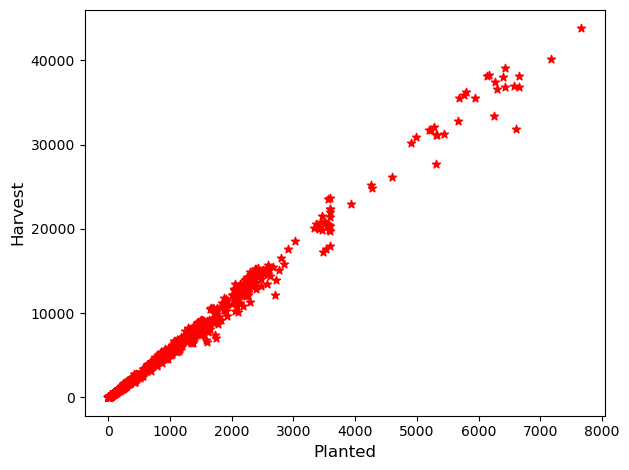

In [17]:
# The dependency 収穫量 -> 作付面積 -> 10a当たり収量
import matplotlib.pyplot as plt

plt.scatter(clean_harvest_data['作付面積'], clean_harvest_data['収穫量'], marker='*', c='r', label="Dependency")

plt.xlabel('Planted', fontsize=12)
plt.ylabel('Harvest', fontsize=12)

plt.tight_layout()
plt.show

In [18]:
# SAVE
clean_harvest_data.to_csv("../datasets/filtered_harvest.csv", index=False)